# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Lea"
ln1 = "Bresson"
fn2 = "Eya"
ln2 = "Kalboussi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_bresson_lea_and_kalboussi_eya.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [15]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [16]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [17]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [18]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [19]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [21]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)


In [41]:

_A

array([[-0.64574753,  0.77553216, -0.75092737, ...,  1.15319728,
         0.9035666 ,  0.80783745],
       [ 0.73774317, -0.61178801, -1.85979155, ...,  1.5760969 ,
         0.04977772, -0.49720897],
       [-0.2929697 ,  2.31621032,  1.92494053, ..., -0.08279457,
         1.41831174,  0.00886576],
       ..., 
       [-1.46622855,  1.55950904,  0.33813055, ..., -0.77646073,
        -0.20249232,  1.02226154],
       [ 0.67418886,  0.09579585, -2.64788424, ..., -0.39257501,
        -0.06449172, -0.37910714],
       [ 0.71373126, -1.0300608 ,  0.71560708, ...,  0.10536265,
        -0.48755853,  3.48875775]])

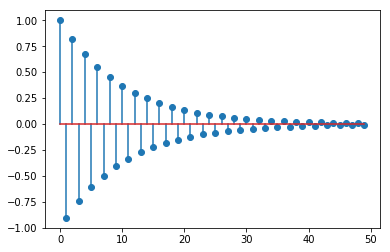

In [23]:
plt.stem(x_model_truth);

In [24]:
_A.shape
_A

array([[-0.64574753,  0.77553216, -0.75092737, ...,  1.15319728,
         0.9035666 ,  0.80783745],
       [ 0.73774317, -0.61178801, -1.85979155, ...,  1.5760969 ,
         0.04977772, -0.49720897],
       [-0.2929697 ,  2.31621032,  1.92494053, ..., -0.08279457,
         1.41831174,  0.00886576],
       ..., 
       [-1.46622855,  1.55950904,  0.33813055, ..., -0.77646073,
        -0.20249232,  1.02226154],
       [ 0.67418886,  0.09579585, -2.64788424, ..., -0.39257501,
        -0.06449172, -0.37910714],
       [ 0.71373126, -1.0300608 ,  0.71560708, ...,  0.10536265,
        -0.48755853,  3.48875775]])

In [14]:
_b

array([-0.36117998,  0.54386438,  0.01610998, ...,  0.70571816,
       -4.73102701,  2.49518222])

### Numerically check loss and gradient

In [27]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.6338605994966443e-06

In [26]:
lbda = 1. / n ** (0.5)
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.9380350189091682e-07

### Choice of the model

In [12]:
#model = LinReg(_A, _b, lbda)
model = LogReg(_A, _b, lbda)

### Compute the theoretical step-size for FISTA

In [28]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.765908173332


### Get a very precise minimum to compute distances to minimum

In [40]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)
x_min

0.5319555513349933


array([ 0.98885096, -0.90262658,  0.80048726, -0.7392255 ,  0.67930531,
       -0.59055026,  0.53855288, -0.4867132 ,  0.4379693 , -0.41004915,
        0.36628062, -0.3448948 ,  0.30340621, -0.27150758,  0.23997282,
       -0.23280294,  0.19489653, -0.17962515,  0.16594878, -0.14986616,
        0.11405396, -0.11796476,  0.10730275, -0.09095908,  0.10531234,
       -0.07144628,  0.06961359, -0.06924001,  0.03612965, -0.05669841,
        0.07131896, -0.0609356 ,  0.04838167, -0.04044668,  0.03314908,
       -0.03019194,  0.01452312, -0.02480255,  0.00588839, -0.02459279,
        0.02871629, -0.02814117,  0.02950214, -0.01908382,  0.01173763,
       -0.00395026, -0.00537087, -0.00965287,  0.00634826, -0.0072858 ])

<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [30]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [31]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [17]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for i in range(n_iter):
        
        x -=  step * grad(x)

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [18]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.43e-01 | 2.51e+00 | 4.0107e-03
      10 | 6.33e-02 | 1.79e+00 | 2.6069e-02
      20 | 3.29e-02 | 1.33e+00 | 3.8100e-02
      30 | 1.81e-02 | 9.99e-01 | 4.8127e-02
      40 | 1.02e-02 | 7.61e-01 | 5.9162e-02


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [19]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        x_new = y - step * grad(y)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1)/ t_new) * (x_new - x)
        x, t = x_new, t_new

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [20]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.43e-01 | 2.51e+00 | 2.0056e-03
      10 | 2.47e-02 | 1.16e+00 | 1.8047e-02
      20 | 7.01e-05 | 5.77e-02 | 3.4091e-02
      30 | 7.50e-04 | 2.15e-01 | 5.0135e-02
      40 | 1.68e-05 | 3.12e-02 | 6.6176e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [21]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.23e-01 | 2.32e+00 | 4.0126e-03
      10 | 3.43e-05 | 3.12e-02 | 3.5095e-02
      20 | 3.41e-08 | 1.10e-03 | 6.6178e-02
Optimization terminated successfully.
         Current function value: 0.523644
         Iterations: 25
         Function evaluations: 51
         Gradient evaluations: 51


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [22]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.68e-01 | 2.05e+00 | 3.0081e-03
      10 | 6.90e-05 | 4.32e-02 | 1.8050e-02
      20 | 8.19e-09 | 5.14e-04 | 3.3089e-02


### A first numerical comparison of deterministic solvers

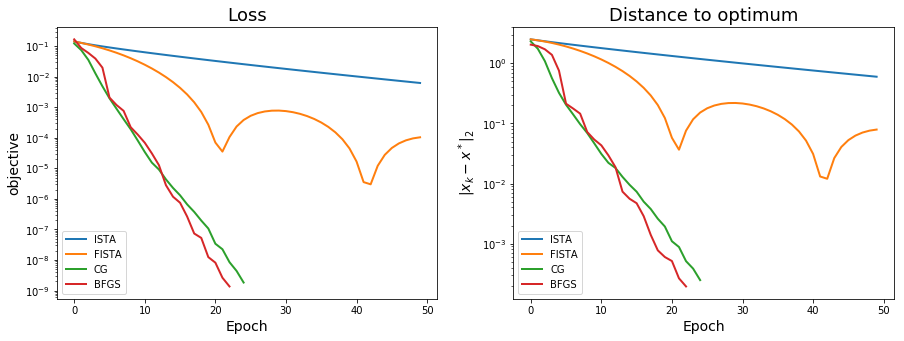

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

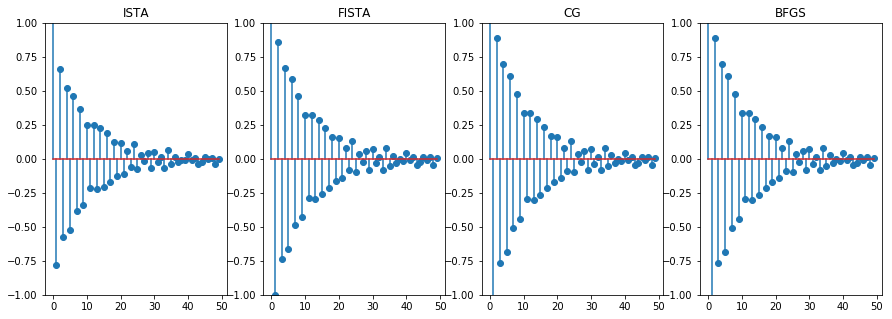

In [24]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about FISTA? is it suprising ?

#### Comments: 


- The loss and distance to optimum of the FISTA algorithm oscillate because FISTA is not a gradient descent (the objective is not monotonous): we compute at each iteration $x= y -\nabla(y)$ and we have no proof that $f(x) > f\Big(y - \nabla(y)\Big)$ so the objective can increase from one iteration to another one but still converges to the minimum.


- For ** a logistic regression** with a correlation between the features equals to 0.7 (default value in the section *"Generate a dataset"*), FISTA and ISTA have approximately the same rate of convergence and we notice that FISTA converges faster at the beginning (it's due to the fact that it is not a gradient descent) - see graph above. However, for **a linear regression** (not depicted here - see at the end of the document) with a correlation equals to 0.1 (default value in the section *"Generate a dataset"*), ISTA converges faster than FISTA because the conditioning of the problem is very good (if the correlation increases, FISTA becomes more performant). 


- For both cases (linear and logistic), the scipy.optimize's CG and BFGS converge faster than ISTA and FISTA. More precisely, after a few iterations, BFGS has the largest rate of convergence.




<a id='stoc'></a> 
## 4. Stochastic methods

In [32]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [33]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]

        x -= (step / (np.sqrt(idx + 1))) * grad_i (i, x)
       
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [34]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.77e+02 | 1.88e+01 | 0.0000e+00
      10 | 4.79e-02 | 2.99e-01 | 1.2748e+00
      20 | 2.34e-02 | 2.13e-01 | 2.3988e+00
      30 | 3.53e-02 | 2.58e-01 | 3.5295e+00
      40 | 2.18e-02 | 2.11e-01 | 4.6109e+00


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [35]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    avg_grad = np.zeros(d)

    for idx in range(n_iter):

        i = iis[idx]
        y = grad_i(i, x)
        avg_grad += 1. / n * (y - gradient_memory[i, :]) 
        gradient_memory[i, :] = y
        x -= step * avg_grad

        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [36]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.27e+00 | 2.33e+00 | 0.0000e+00
      10 | 4.00e-02 | 2.88e-01 | 1.4585e+00
      20 | 6.61e-04 | 3.61e-02 | 2.8332e+00
      30 | 2.74e-05 | 7.39e-03 | 4.2703e+00
      40 | 7.12e-07 | 1.23e-03 | 6.0297e+00


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [37]:
def svrg(x_init, iis, grad, grad_i, loss, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter):
        x_old = x.copy()
        mu = grad(x)
    
        for k in range(n):
            i = iis[idx * n + k]
            x -= step * (grad_i(i,x) - grad_i(i,x_old) + mu)   
        
        # Update metrics after each full pass on data.
        if callback is not None:
            callback(x)
        if (idx % 5) == 0:
            print("After iteration {} loss is now: ".format(k), loss(x))
    return x 
         

In [38]:
if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)
    
    
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, model.loss, n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.45e-01 | 1.12e+00 | 2.3440e-01
After iteration 9999 loss is now:  1.1769080592627654
After iteration 9999 loss is now:  0.5378342295970421
      10 | 5.33e-05 | 1.00e-02 | 1.9937e+00
After iteration 9999 loss is now:  0.5320088427693906
After iteration 9999 loss is now:  0.5319557253719861
      20 | 1.68e-09 | 5.85e-05 | 3.5245e+00
After iteration 9999 loss is now:  0.5319555530188248
After iteration 9999 loss is now:  0.5319555513433223
      30 | 6.34e-14 | 3.52e-07 | 5.0791e+00
After iteration 9999 loss is now:  0.5319555513350567
After iteration 9999 loss is now:  0.5319555513349936
      40 | 0.00e+00 | 1.20e-09 | 6.6585e+00
After iteration 9999 loss is now:  0.5319555513349933
After iteration 9999 loss is now:  0.5319555513349933


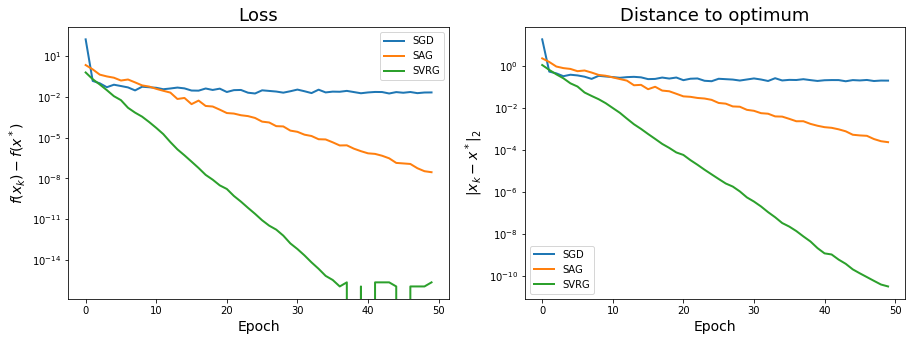

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

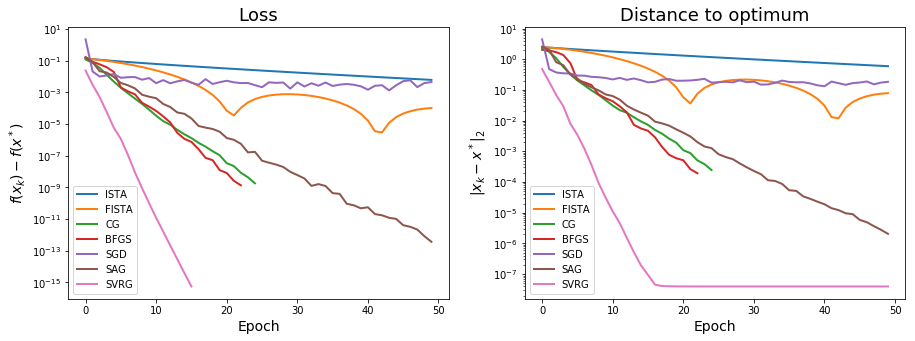

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

## Comments :

- SGD : The algorithm is initially fast and then very slow and does not converge to the minimum. The algorithm gets closer to $x^* $ but keeps swinging around the minimum. 

- SAG : The algorithm is faster than SGD, but is still a bit slow, convergence is not reached yet after 50 iterations. However, we can clearly see that when using SAG we get closer to the minimum. Yet, the variance of both algorithms is still quite high. The speed of the SAG algorithm is comparable to the CG and BFGS one, implemented in scipy. 

- SVRG : This algorithm solves the problem of high variance. When deducting the term ( $z - \mathbb{E}[z]$), the estimation of the gradient is less unstable, which is clearly the case here, since the graph of the SVRG method is far less fluctuating that the SAG and SGD ones. 

For a **logistic regression** with a correlation of the features equals to 0.7, the SVRG algorithm outperforms all the presented algorithms. This result is due to the conditioning of the problem and is not observed with other correlation rates (we will see this later).


Note that for a **linear regression** with a correlation of the features equals to 0.1, the deterministic methods are better, especially the scipy.optimize's CG and BFGS (see the next section: *linear regression with high ridge*). 





## 7. Comparisons

In [34]:
def Inspectors(model):
    
    step = 1. / model.lipschitz_constant()
    
    # Conjugate gradient
    cg_inspector = inspector(model.loss, x_min, verbose=True) 
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)
    
    # BFGS
    bfgs_inspector = inspector(model.loss, x_min, verbose=True) 
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)
    
    # ISTA
    ista_inspector = inspector(model.loss, x_min, verbose=True) 
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)
    
    # FISTA
    fista_inspector = inspector(model.loss, x_min, verbose=True) 
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)
    
    # SGD
    sgd_inspector = inspector(model.loss, x_min, verbose=True) 
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)
    
    # SAG
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
        
    sag_inspector = inspector(model.loss, x_min, verbose=True) 
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)
    
    # SVRG
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
        
    svrg_inspector = inspector(model.loss, x_min, verbose=True) 
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter, step, callback=svrg_inspector)

    
    return ([ista_inspector, fista_inspector, cg_inspector, bfgs_inspector, sgd_inspector,
                                         sag_inspector, svrg_inspector])

In [35]:
def plot (inspectors, sgd=False):
    if index == 1:
        title1 = "Loss, correlation = %.02f" %Corr[i]
        title2 = "Distance to optimum, correlation = %.02f" %Corr[i]
    else:
        title1 = "Loss" 
        title2 = "Distance to optimum"

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    
    if (sgd==True):
        solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]
        inspec = inspectors
    else:
        solvers = ["ISTA", "FISTA", "CG", "BFGS", "SAG", "SVRG"]
        inspec = inspectors[:4] + inspectors[5:]

    for insp in inspec:
        plt.semilogy(insp.obj, lw=2)
        plt.title(title1, fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for insp in inspec:
        plt.semilogy(insp.err, lw=2)
        plt.title(title2, fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

    plt.legend(solvers);

# Impact of the ridge regularization

# 1. Logistic regression : 
## Low ridge

In [36]:
index = 0 # Tool for the graph titles

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.7)
lbda = 1. / n
model = LogReg(A, b, lbda)

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

low_ridge = Inspectors(model)

   it    |   obj    |   err    |   time  
       0 | 1.68e-01 | 3.67e+00 | 4.0381e-03
      10 | 1.29e-04 | 7.15e-02 | 3.7102e-02
      20 | 5.69e-08 | 1.35e-03 | 6.9184e-02
Optimization terminated successfully.
         Current function value: 0.478421
         Iterations: 26
         Function evaluations: 53
         Gradient evaluations: 53
   it    |   obj    |   err    |   time  
       0 | 2.07e-01 | 3.38e+00 | 2.0070e-03
      10 | 1.72e-04 | 7.81e-02 | 2.4065e-02
      20 | 1.14e-07 | 2.08e-03 | 4.1110e-02
   it    |   obj    |   err    |   time  
       0 | 1.90e-01 | 3.88e+00 | 2.0053e-03
      10 | 1.07e-01 | 3.16e+00 | 1.4038e-02
      20 | 6.92e-02 | 2.64e+00 | 2.9078e-02
      30 | 4.73e-02 | 2.25e+00 | 4.5120e-02
      40 | 3.36e-02 | 1.94e+00 | 6.5173e-02
   it    |   obj    |   err    |   time  
       0 | 1.90e-01 | 3.88e+00 | 1.0040e-03
      10 | 5.91e-02 | 2.48e+00 | 2.1056e-02
      20 | 7.19e-03 | 9.58e-01 | 4.7125e-02
      30 | 1.20e-05 | 3.08e-02 | 7.0188e-02


## High ridge

In [37]:
A, b = simu_logreg(x_model_truth, n, std=1., corr=0.7)
lbda = 1. / np.sqrt(n)
model = LogReg(A, b, lbda)

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

high_ridge = Inspectors(model)

   it    |   obj    |   err    |   time  
       0 | 1.21e-01 | 2.29e+00 | 5.0116e-03
      10 | 3.71e-05 | 3.28e-02 | 4.0106e-02
      20 | 4.92e-08 | 1.17e-03 | 7.6202e-02
Optimization terminated successfully.
         Current function value: 0.523687
         Iterations: 25
         Function evaluations: 51
         Gradient evaluations: 51
   it    |   obj    |   err    |   time  
       0 | 1.68e-01 | 2.03e+00 | 4.0109e-03
      10 | 6.66e-05 | 4.35e-02 | 2.1058e-02
      20 | 8.39e-09 | 4.48e-04 | 3.7099e-02
   it    |   obj    |   err    |   time  
       0 | 1.41e-01 | 2.47e+00 | 1.0023e-03
      10 | 6.14e-02 | 1.76e+00 | 1.0026e-02
      20 | 3.17e-02 | 1.30e+00 | 2.0054e-02
      30 | 1.73e-02 | 9.73e-01 | 2.9079e-02
      40 | 9.74e-03 | 7.38e-01 | 3.9103e-02
   it    |   obj    |   err    |   time  
       0 | 1.41e-01 | 2.47e+00 | 0.0000e+00
      10 | 2.37e-02 | 1.13e+00 | 9.0249e-03
      20 | 5.54e-05 | 4.96e-02 | 1.8044e-02
      30 | 7.23e-04 | 2.10e-01 | 2.9078e-02


## Graphs : Low ridge


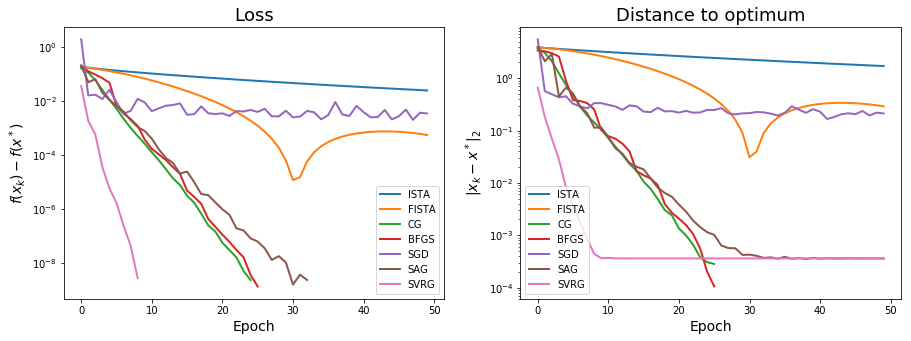

In [38]:
plot(low_ridge,True)

## High ridge

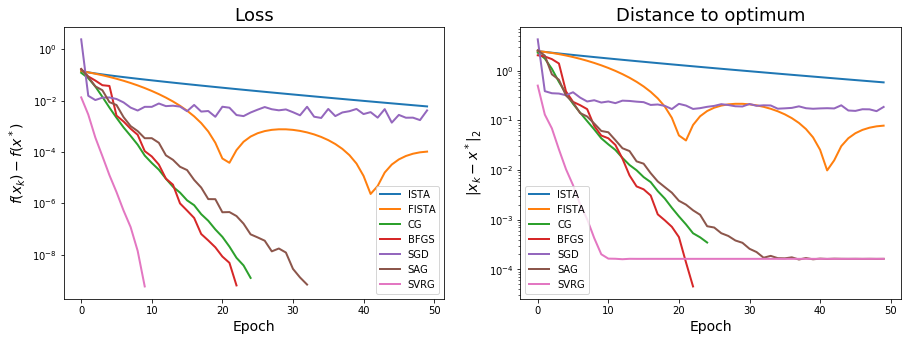

In [39]:
plot(high_ridge,True)

### Comments:

**For high ridge :** when using $\lambda=\frac{1}{n}$, the SAG algorithm is slower than the BFGS and CG algorithms. 


**For low ridge :** when using $\lambda=\frac{1}{\sqrt n}$, the SAG algorithm is almost as fast as the BFGS and CG algorithms. 


The algorithms are not that much affected by the choice of $\lambda$: the conclusions drawn in the previous section (i.e. with a high ridge regularization) remain the same when using low ridge regularization.

# 2. Linear regression:
## Low ridge

In [40]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
lbda = 1. / n
model = LinReg(A, b, lbda)

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

low_ridge = Inspectors(model)

   it    |   obj    |   err    |   time  
       0 | 1.97e-02 | 2.02e-01 | 5.0123e-03
Optimization terminated successfully.
         Current function value: 0.497678
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
   it    |   obj    |   err    |   time  
       0 | 7.74e-01 | 1.36e+00 | 3.0067e-03
   it    |   obj    |   err    |   time  
       0 | 2.81e-01 | 8.22e-01 | 1.0026e-03
      10 | 1.20e-09 | 5.59e-05 | 9.0227e-03
      20 | -1.59e-11 | 5.15e-06 | 1.6042e-02
      30 | -1.59e-11 | 5.15e-06 | 2.4067e-02
      40 | -1.59e-11 | 5.15e-06 | 3.1086e-02
   it    |   obj    |   err    |   time  
       0 | 2.81e-01 | 8.22e-01 | 1.0033e-03
      10 | 1.02e-08 | 1.56e-04 | 8.0199e-03
      20 | -1.57e-11 | 5.22e-06 | 1.6044e-02
      30 | -1.59e-11 | 5.15e-06 | 2.3061e-02
      40 | -1.59e-11 | 5.15e-06 | 2.9077e-02
   it    |   obj    |   err    |   time  
       0 | 5.11e+02 | 3.07e+01 | 0.0000e+00
      10 | 5.83e-02 | 3.36e-01 | 1.1440e+00

## High ridge

In [41]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
lbda = 1. / np.sqrt(n)
model = LinReg(A, b, lbda)
#tep = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

high_ridge = Inspectors(model)

   it    |   obj    |   err    |   time  
       0 | 2.04e-02 | 2.02e-01 | 5.0137e-03
Optimization terminated successfully.
         Current function value: 0.536773
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
   it    |   obj    |   err    |   time  
       0 | 7.24e-01 | 1.32e+00 | 3.0081e-03
   it    |   obj    |   err    |   time  
       0 | 2.95e-01 | 8.50e-01 | 6.0153e-03
      10 | 1.61e-09 | 6.39e-05 | 5.4143e-02
      20 | -4.47e-12 | 2.65e-06 | 7.2191e-02
      30 | -4.47e-12 | 2.65e-06 | 8.7231e-02
      40 | -4.47e-12 | 2.65e-06 | 9.6256e-02
   it    |   obj    |   err    |   time  
       0 | 2.95e-01 | 8.50e-01 | 1.0021e-03
      10 | 8.63e-09 | 1.45e-04 | 7.0190e-03
      20 | -4.32e-12 | 2.66e-06 | 1.3038e-02
      30 | -4.47e-12 | 2.65e-06 | 1.9052e-02
      40 | -4.47e-12 | 2.65e-06 | 2.5068e-02
   it    |   obj    |   err    |   time  
       0 | 7.14e+01 | 1.19e+01 | 0.0000e+00
      10 | 4.80e-02 | 3.07e-01 | 1.3466e+

### Low ridge

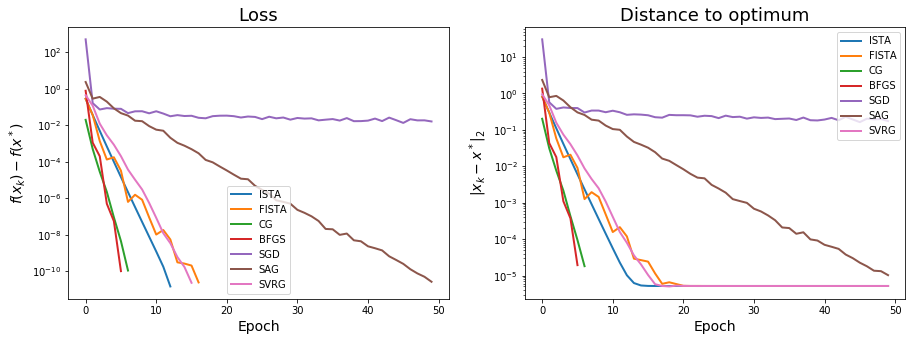

In [42]:
plot(low_ridge,True)

### High ridge

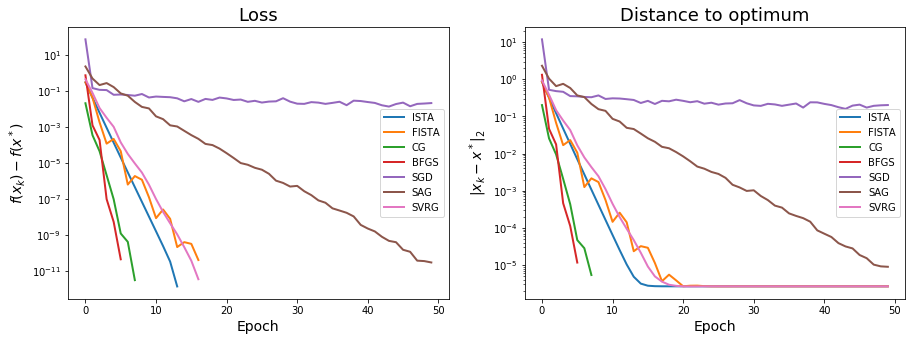

In [43]:
plot(high_ridge,True)

### Comments: 

For the linear regression, we also do not observe significant change when changing the strength of penalization. FISTA is almost as fast as SVRG which is still slower than ISTA for both low and high ridge.  


# Impact of the correlation : High ridge


## 1. Logistic regression

In [44]:
index = 1 # Tool for the graph titles

Corr = [0.1, 0.4, 0.7, 0.9]
lbda = 1. / np.sqrt(n)

In [45]:
All_models=[]
All_inspectors=[]

for i in Corr:
    A, b = simu_logreg(x_model_truth, n, std=1., corr=i)
    model = LogReg(A, b, lbda)
    All_models.append(model)
    
    x_init = np.zeros(d)
    
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
    All_inspectors.append(Inspectors(model))

   it    |   obj    |   err    |   time  
       0 | 3.63e-02 | 1.16e+00 | 1.0027e-02
Optimization terminated successfully.
         Current function value: 0.358953
         Iterations: 10
         Function evaluations: 25
         Gradient evaluations: 25
   it    |   obj    |   err    |   time  
       0 | 1.04e-01 | 1.81e+00 | 4.0112e-03
   it    |   obj    |   err    |   time  
       0 | 1.04e-01 | 1.81e+00 | 1.0023e-03
      10 | 1.88e-03 | 2.91e-01 | 1.1029e-02
      20 | 1.07e-04 | 7.07e-02 | 2.4067e-02
      30 | 6.90e-06 | 1.81e-02 | 3.7099e-02
      40 | 4.61e-07 | 4.68e-03 | 5.2138e-02
   it    |   obj    |   err    |   time  
       0 | 1.04e-01 | 1.81e+00 | 1.0028e-03
      10 | 1.88e-04 | 9.53e-02 | 1.2033e-02
      20 | 1.29e-05 | 2.47e-02 | 2.5068e-02
      30 | 1.12e-06 | 7.31e-03 | 3.9108e-02
      40 | 7.89e-08 | 1.94e-03 | 5.2140e-02
   it    |   obj    |   err    |   time  
       0 | 1.23e+00 | 4.36e+00 | 1.0016e-03
      10 | 3.77e-03 | 2.35e-01 | 2.1166e+00
  

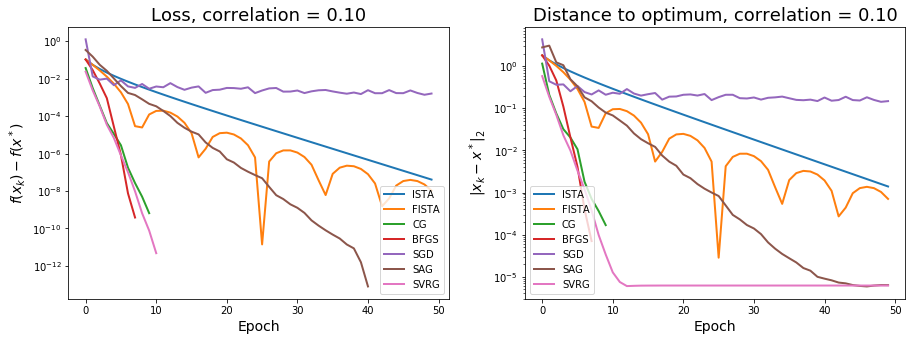

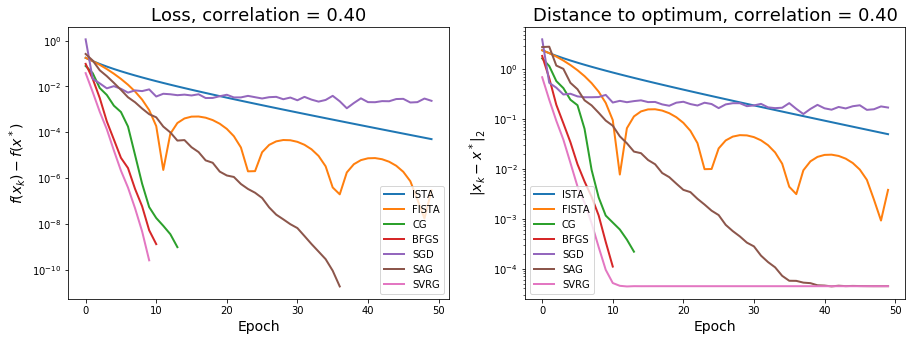

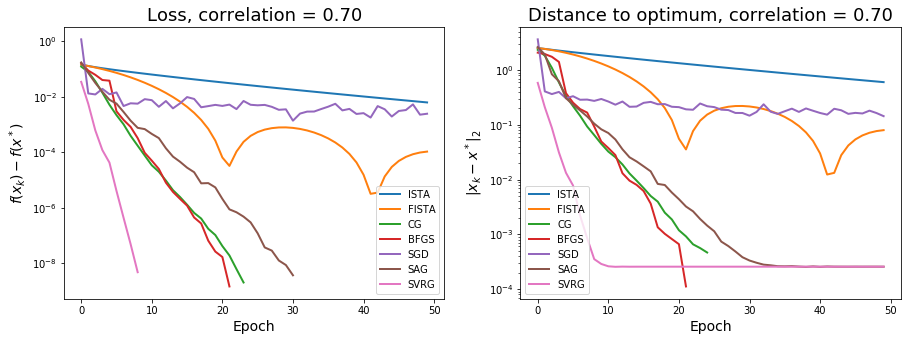

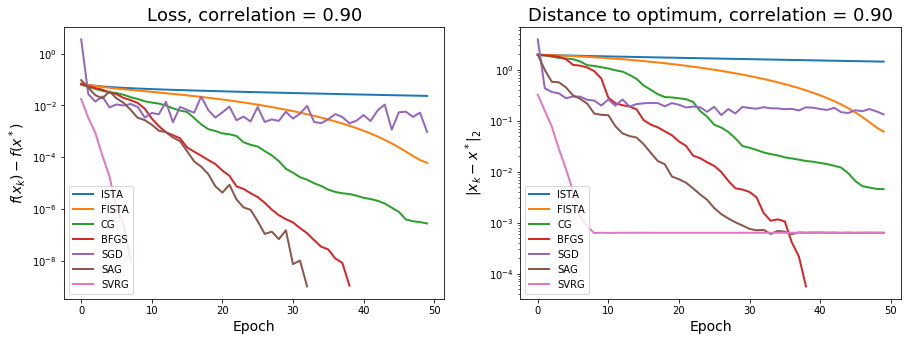

In [46]:
for i in range (len(Corr)):
    plot(All_inspectors[i],True)

### Comments: 

For the **logistic regression**, we observe that when the correlation is low, the SVRG and the scipy.optimize's BFGS and CG perform well.

When increasing the correlation, with high ridge regularization, both CG and BFGS from scipy become slow and fluctuant, comparable to SAG in terms of speed of convergence, and even worse when correlation = 0.9, which is bad. Therefore the batch (deterministic) methods are very sensitive to the level of correlation: as the features correlation increases, the algorithms' speed of convergence decreases and the distance to optimum increases. More precisely, ISTA and FISTA suffer the most from bad conditioning. 

On the contrary, stochastic methods are less sensitive to bad conditioning: when the correlation is large, SGD is still bad while SVRG and SAG perform relatively good in terms of speed of convergence. More precisely, we can see that SVRG converges well and roughly at the same number of iteration whether correlation is high or not. In addition, the speed of convergence of SAG is a bit faster with large correlation rates. 
The distance to optimum increases as the correlation gets larger though.



## 2. Linear regression

In [47]:
All_models = []
All_inspectors = []

for i in Corr:
    A, b = simu_linreg(x_model_truth, n, std=1., corr=i)
    model = LinReg(A, b, lbda)
    All_models.append(model)
    
    x_init = np.zeros(d)
    
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
    All_inspectors.append(Inspectors(model))

   it    |   obj    |   err    |   time  
       0 | 2.78e-02 | 2.35e-01 | 3.5114e-03
Optimization terminated successfully.
         Current function value: 0.524672
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
   it    |   obj    |   err    |   time  
       0 | 7.61e-01 | 1.33e+00 | 2.5067e-03
   it    |   obj    |   err    |   time  
       0 | 2.71e-01 | 7.98e-01 | 1.0023e-03
      10 | 8.89e-10 | 4.91e-05 | 1.2032e-02
      20 | -4.08e-11 | 7.93e-06 | 2.3061e-02
      30 | -4.08e-11 | 7.93e-06 | 3.0581e-02
      40 | -4.08e-11 | 7.93e-06 | 4.0608e-02
   it    |   obj    |   err    |   time  
       0 | 2.71e-01 | 7.98e-01 | 1.0026e-03
      10 | 1.10e-08 | 1.62e-04 | 9.0289e-03
      20 | -4.06e-11 | 7.91e-06 | 1.5044e-02
      30 | -4.08e-11 | 7.93e-06 | 2.4067e-02
      40 | -4.08e-11 | 7.93e-06 | 3.0084e-02
   it    |   obj    |   err    |   time  
       0 | 1.51e+02 | 1.74e+01 | 5.0545e-04
      10 | 3.91e-02 | 2.71e-01 | 1.2223e+

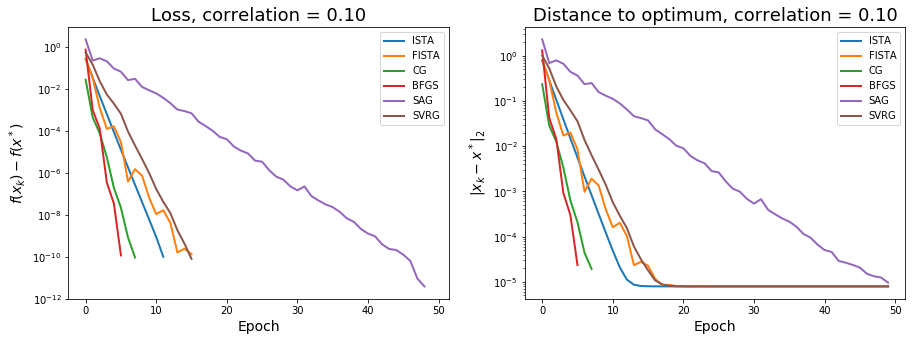

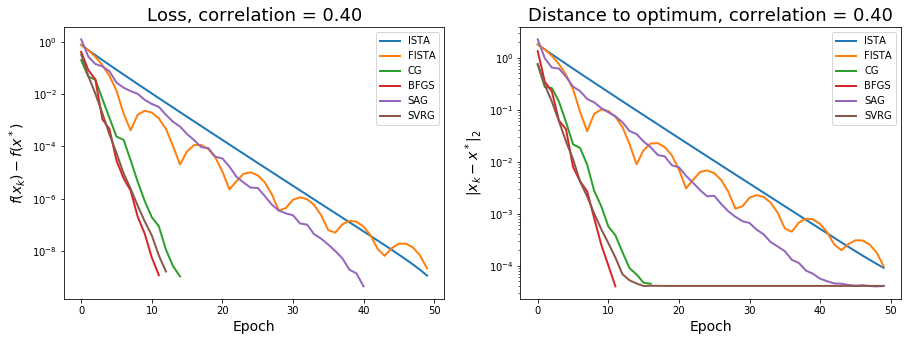

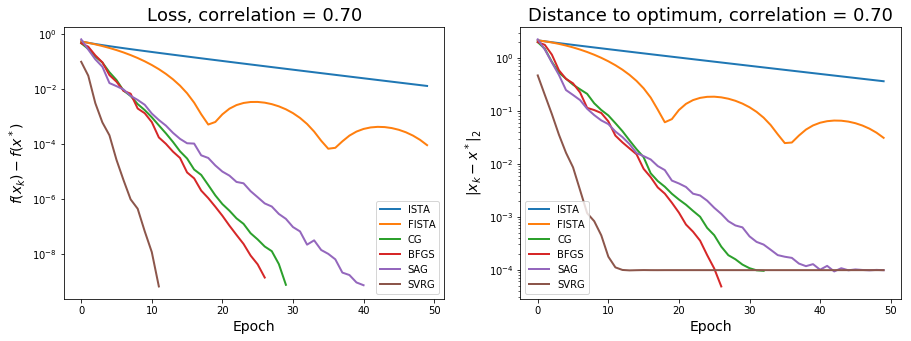

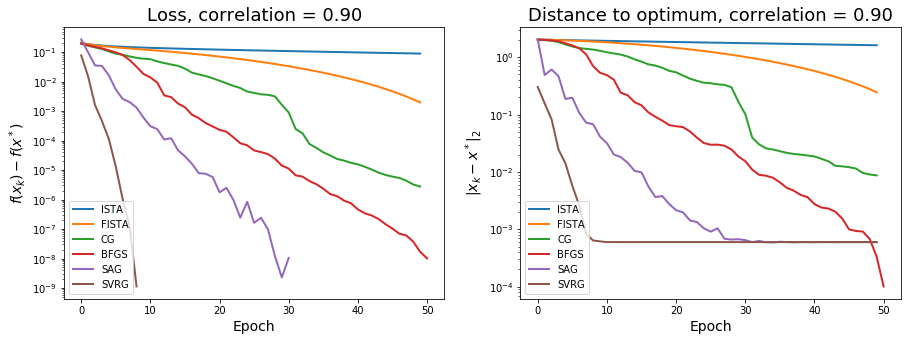

In [48]:
for i in range (len(Corr)):
    plot(All_inspectors[i],False)

### Comments: 

For **the linear regression**, we decided to plot all graphs except the one returned by SGD algorithm. When plotting SGD curves, the convergence of other algorithms can not be plotted since the distance to minimum and the loss reach large number. For matter of scale, we will omit SGD curves (the performance of this algorithm is bad for any level of correlation).

When increasing the level of correlation, ISTA and FISTA methods are the most affected by this bad conditioning. Those two become slower and slower. Also, CG and BFGS methods, implemented in scipy, do not converge that fast when increasing the correlation. As we can see on the graphs, CG and BFGS have become slower than SAG and SVRG. 

As for SVRG algorithm, increasing the correlation of the features does not affect that much the speed of convergence. Concerning the SAG, we observe that the convergence is faster with large correlation (but remains relatively slow). However, for both algorithms (SVRG and SAG) it does affect the minimum reached. When correlation is low, the convergence point is less than $10^{-5}$ but when correlation increases, the algorithms converge to a minima of order $10^{-4}$ .


# Impact of the correlation : Low ridge

## 1. Logistic regression

In [49]:
index = 1 # Tool for the graph titles
lbda = 1. / n

In [50]:
All_models=[]
All_inspectors=[]

for i in Corr:
    A, b = simu_logreg(x_model_truth, n, std=1., corr=i)
    model = LogReg(A, b, lbda)
    All_models.append(model)
    
    x_init = np.zeros(d)
    
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
    All_inspectors.append(Inspectors(model))

   it    |   obj    |   err    |   time  
       0 | 7.42e-02 | 2.38e+00 | 4.5121e-03
      10 | 1.18e-08 | 1.18e-03 | 4.3617e-02
Optimization terminated successfully.
         Current function value: 0.307241
         Iterations: 11
         Function evaluations: 33
         Gradient evaluations: 33
   it    |   obj    |   err    |   time  
       0 | 1.51e-01 | 3.05e+00 | 3.0084e-03
   it    |   obj    |   err    |   time  
       0 | 1.45e-01 | 3.01e+00 | 1.5061e-03
      10 | 1.20e-02 | 1.14e+00 | 1.5040e-02
      20 | 3.15e-03 | 6.20e-01 | 2.6069e-02
      30 | 1.02e-03 | 3.63e-01 | 3.7099e-02
      40 | 3.65e-04 | 2.20e-01 | 4.8160e-02
   it    |   obj    |   err    |   time  
       0 | 1.45e-01 | 3.01e+00 | 1.0040e-03
      10 | 5.41e-04 | 2.67e-01 | 1.3536e-02
      20 | 1.87e-04 | 1.64e-01 | 2.5068e-02
      30 | 6.45e-06 | 2.98e-02 | 3.5095e-02
      40 | 3.49e-06 | 2.19e-02 | 4.5121e-02
   it    |   obj    |   err    |   time  
       0 | 1.29e+00 | 5.38e+00 | 5.0044e-04
  

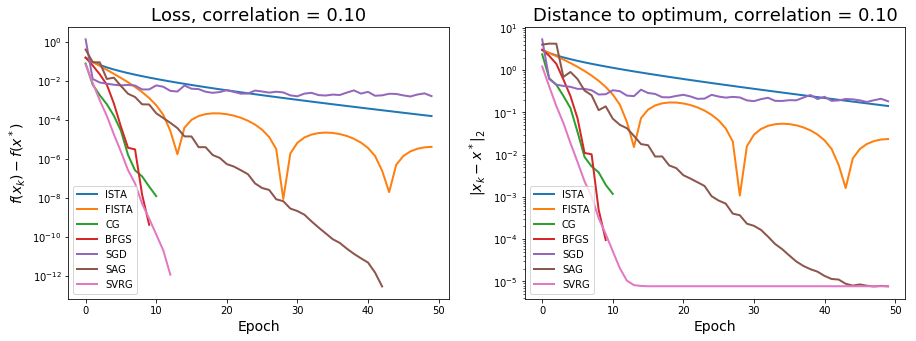

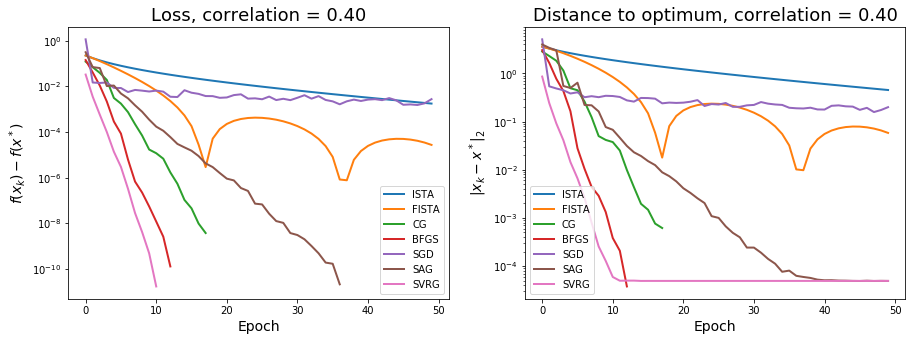

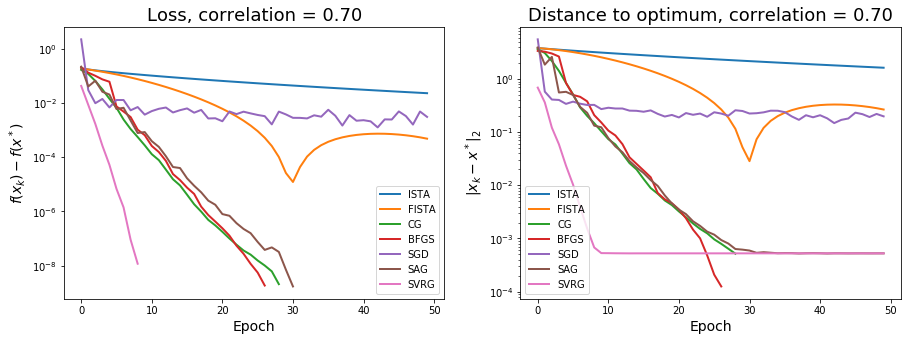

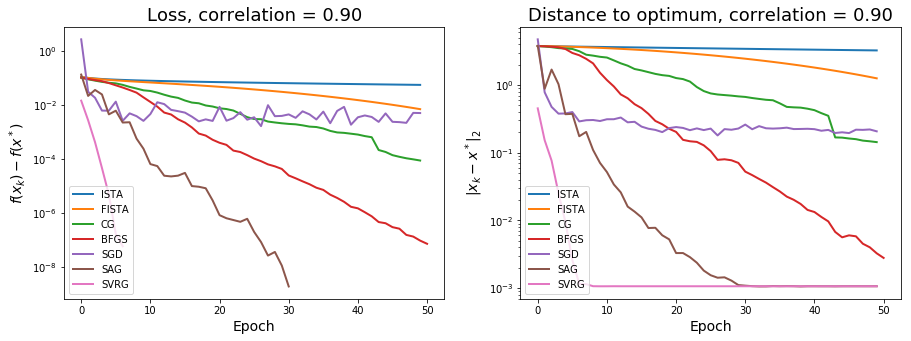

In [51]:
for i in range (len(Corr)):
    plot(All_inspectors[i],True)

## 2. Linear regression 

In [52]:
All_models = []
All_inspectors = []

for i in Corr:
    A, b = simu_linreg(x_model_truth, n, std=1., corr=i)
    model = LinReg(A, b, lbda)
    All_models.append(model)
    
    x_init = np.zeros(d)
    
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
    All_inspectors.append(Inspectors(model))

   it    |   obj    |   err    |   time  
       0 | 1.49e-02 | 1.79e-01 | 3.0096e-03
Optimization terminated successfully.
         Current function value: 0.503614
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
   it    |   obj    |   err    |   time  
       0 | 7.74e-01 | 1.37e+00 | 2.5079e-03
   it    |   obj    |   err    |   time  
       0 | 2.95e-01 | 8.49e-01 | 5.0211e-04
      10 | 1.30e-09 | 5.86e-05 | 1.0528e-02
      20 | -1.12e-11 | 4.25e-06 | 2.0554e-02
      30 | -1.12e-11 | 4.25e-06 | 3.0080e-02
      40 | -1.12e-11 | 4.25e-06 | 3.8102e-02
   it    |   obj    |   err    |   time  
       0 | 2.95e-01 | 8.49e-01 | 5.0116e-04
      10 | 9.85e-09 | 1.55e-04 | 8.5235e-03
      20 | -1.10e-11 | 4.16e-06 | 3.1084e-02
      30 | -1.12e-11 | 4.25e-06 | 4.3618e-02
      40 | -1.12e-11 | 4.25e-06 | 5.7654e-02
   it    |   obj    |   err    |   time  
       0 | 1.09e+02 | 1.42e+01 | 5.0044e-04
      10 | 5.23e-02 | 3.30e-01 | 1.5215e+00

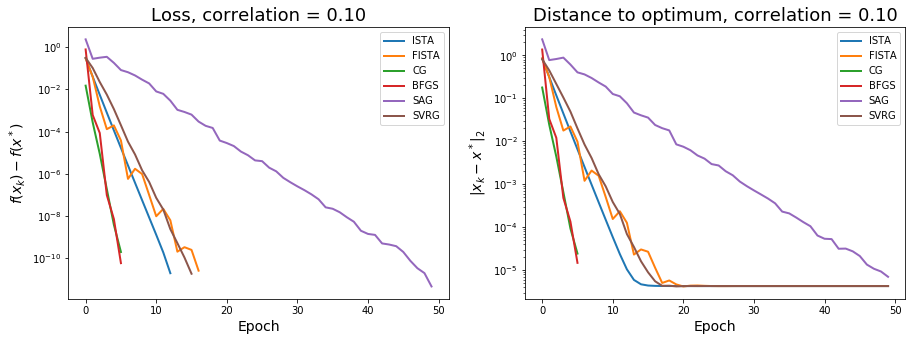

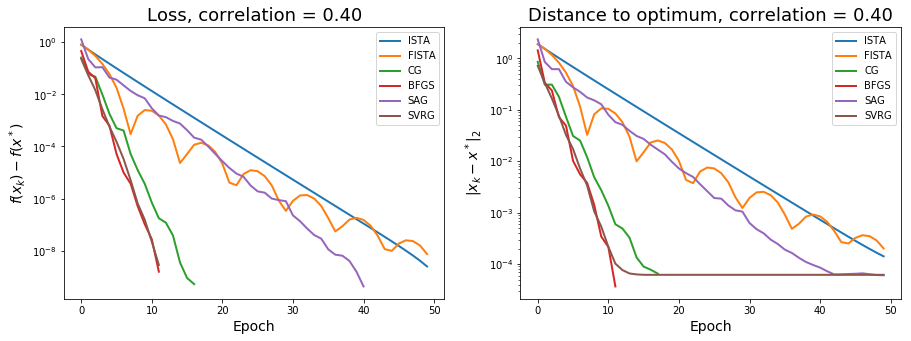

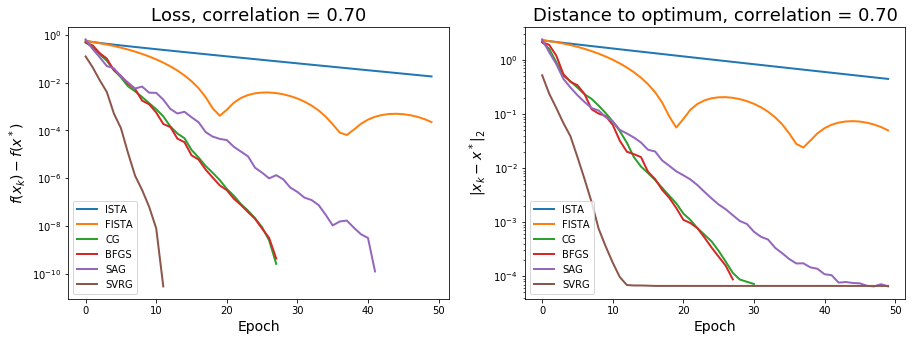

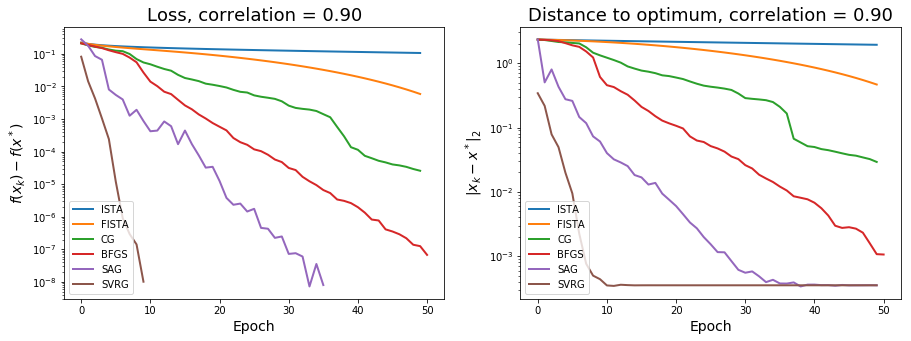

In [53]:
for i in range (len(Corr)):
    plot(All_inspectors[i],False)

### Comments: 

With low ridge, the conclusions are quite the same than the ones before. Stochastic methods are stable when changing the value of correlation (except SGD algorithm with linear regression - not depicted here since the distance to the minimum reaches $10^{49}$) whereas deterministic methods do not perform well with bad conditioning. 


Furthermore, we observe also that the distance to the minimum increases a bit due to bad conditioning for linear and logistic regressions. 







### Conclusion: 
To conclude we have seen that the level of ridge regularization does not have a significant impact on the performance of the algorithms studied. On the contrary, deterministic methods are very sensitive to the level of correlation. 

This Lab highlights that stochastic methods are particularly useful in case of bad conditioning (large correlation). More precisely, SVRG is the most efficient algorithm but this method may be expensive in terms of time (SAG could be prefered but would be expensive in terms of memory and we have seen that the convergence is slow). 

When the correlation between the features is low, one should prefer CG or BFGS (or SVRG in case of logistic regression).